In [1]:
import pyforest
from pyforest import *

# Data Loading

In [2]:
from scipy.io import loadmat
import os

# Load SURF features for webcam and DSLR
surf_dir = '../data/surf/'

data_webcam = loadmat(os.path.join(surf_dir, 'webcam.mat'))
X_webcam_surf = data_webcam['fts']   # Feature matrix
y_webcam_surf = data_webcam['labels'].flatten()  # Labels (flatten to avoid issues with shape)

data_dslr = loadmat(os.path.join(surf_dir, 'dslr.mat'))
X_dslr_surf = data_dslr['fts']  # Feature matrix
y_dslr_surf = data_dslr['labels'].flatten()  # Labels


# Load CaffeNet features for webcam and DSLR
cafN_dir = '../data/CaffeNet/'

data_webcam = loadmat(os.path.join(cafN_dir, 'webcam.mat'))
X_webcam_caf = data_webcam['fts']   # Feature matrix
y_webcam_caf = data_webcam['labels'].flatten()  # Labels (flatten to avoid issues with shape)

data_dslr = loadmat(os.path.join(surf_dir, 'dslr.mat'))
X_dslr_caf = data_dslr['fts']  # Feature matrix
y_dslr_caf = data_dslr['labels'].flatten()  # Labels



In [3]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Apply z-score normalization to both Webcam and DSLR feature matrices
X_webcam_surf = scaler.fit_transform(X_webcam_surf)  # Normalize Webcam features
X_dslr_surf = scaler.fit_transform(X_dslr_surf)      # Normalize DSLR features
X_webcam_caf = scaler.fit_transform(X_webcam_caf)  # Normalize Webcam features
X_dslr_caf = scaler.fit_transform(X_dslr_caf)      # Normalize DSLR features


In [4]:
# Checking the shape of the features and labels of SURF
print(f"Webcam feature matrix shape: {X_webcam_surf.shape}")
print(f"DSLR feature matrix shape: {X_dslr_surf.shape}")

print(f"Webcam labels shape: {y_webcam_surf.shape}")
print(f"DSLR labels shape: {y_dslr_surf.shape}")

# Get a quick overview of the data
print(f"First 5 labels in Webcam: {y_webcam_surf[:5]}")
print(f"First 5 labels in DSLR: {y_dslr_surf[:5]}")

# Checking the shape of the features and labels of CaffeNet
print(f"Webcam feature matrix shape: {X_webcam_caf.shape}")
print(f"DSLR feature matrix shape: {X_dslr_caf.shape}")

print(f"Webcam labels shape: {y_webcam_caf.shape}")
print(f"DSLR labels shape: {y_dslr_caf.shape}")


Webcam feature matrix shape: (295, 800)
DSLR feature matrix shape: (157, 800)
Webcam labels shape: (295,)
DSLR labels shape: (157,)
First 5 labels in Webcam: [1 1 1 1 1]
First 5 labels in DSLR: [1 1 1 1 1]
Webcam feature matrix shape: (295, 4096)
DSLR feature matrix shape: (157, 800)
Webcam labels shape: (295,)
DSLR labels shape: (157,)


# EDA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Count the number of occurrences for each class in both domains
unique_webcam, counts_webcam = np.unique(y_webcam, return_counts=True)
unique_dslr, counts_dslr = np.unique(y_dslr, return_counts=True)

# Plot class distributions for Webcam and DSLR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(unique_webcam, counts_webcam)
plt.title('Class Distribution - Webcam')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.bar(unique_dslr, counts_dslr)
plt.title('Class Distribution - DSLR')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Get a summary of statistics for the Webcam and DSLR feature matrices
print("Summary statistics for Webcam features:")
print(f"Mean: {np.mean(X_webcam, axis=0)[:5]}")
print(f"Standard deviation: {np.std(X_webcam, axis=0)[:5]}")
print(f"Min values: {np.min(X_webcam, axis=0)[:5]}")
print(f"Max values: {np.max(X_webcam, axis=0)[:5]}")

print("\nSummary statistics for DSLR features:")
print(f"Mean: {np.mean(X_dslr, axis=0)[:5]}")
print(f"Standard deviation: {np.std(X_dslr, axis=0)[:5]}")
print(f"Min values: {np.min(X_dslr, axis=0)[:5]}")
print(f"Max values: {np.max(X_dslr, axis=0)[:5]}")


In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensionality of both datasets to 2D using PCA
pca = PCA(n_components=2)
X_webcam_pca = pca.fit_transform(X_webcam)
X_dslr_pca = pca.fit_transform(X_dslr)

# Plot the 2D projections of both domains
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_webcam_pca[:, 0], X_webcam_pca[:, 1], c=y_webcam, cmap='jet', s=10)
plt.title('PCA - Webcam')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.subplot(1, 2, 2)
plt.scatter(X_dslr_pca[:, 0], X_dslr_pca[:, 1], c=y_dslr, cmap='jet', s=10)
plt.title('PCA - DSLR')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


# PCA with Dynamice D Selection

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator
from typing import List, Tuple, Optional

def pca_with_dynamic_d(X: np.ndarray, variance_threshold: float = 0.90, plot_variance: bool = False) -> Tuple[np.ndarray, int]:
    """
    Perform PCA with dynamic selection of the number of components based on variance threshold.
    
    Args:
    - X: Feature matrix of shape (n_samples, n_features).
    - variance_threshold: The cumulative variance ratio to be retained (e.g., 0.90 for 90%).
    - plot_variance: Whether to plot the cumulative explained variance.
    
    Returns:
    - X_pca: PCA-transformed feature matrix with optimal number of components.
    - n_components: Number of components selected based on the variance threshold.
    """
    pca = PCA().fit(X)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = explained_variance_ratio.cumsum()
    
    n_components = next(i for i, total in enumerate(cumulative_variance) if total >= variance_threshold) + 1
    
    pca_optimal = PCA(n_components=n_components)
    X_pca = pca_optimal.fit_transform(X)
    
    if plot_variance:
        plt.figure(figsize=(8, 5))
        plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
        plt.axhline(y=variance_threshold, color='r', linestyle='-')
        plt.title(f'Cumulative Explained Variance with Optimal D = {n_components}')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid(True)
        plt.show()
    
    print(f"Optimal number of components to retain {variance_threshold * 100}% variance: {n_components}")
    return X_pca, n_components

def evaluate_pca_performance(X_pca: np.ndarray, y: np.ndarray, classifier: BaseEstimator = KNeighborsClassifier(n_neighbors=1), cv: int = 5) -> float:
    """
    Evaluate PCA performance using cross-validation with a specified classifier.
    
    Args:
    - X_pca: PCA-transformed feature matrix.
    - y: Labels corresponding to the feature matrix.
    - classifier: Classifier to use for evaluation (default: 1-NN).
    - cv: Number of cross-validation folds (default: 5).
    
    Returns:
    - mean_accuracy: Mean cross-validation accuracy score.
    """
    scores = cross_val_score(classifier, X_pca, y, cv=cv)
    mean_accuracy = np.mean(scores)
    return mean_accuracy

def tune_pca_with_visualizations(X: np.ndarray, y: np.ndarray, 
                                 thresholds: List[float] = [0.80, 0.85, 0.90, 0.95, 0.99],
                                 classifier: BaseEstimator = KNeighborsClassifier(n_neighbors=1),
                                 cv: int = 5,
                                 save_plots: bool = False,
                                 plot_prefix: str = "pca_tuning") -> Tuple[PCA, float, int, float]:
    """
    Tune PCA and visualize results for different variance thresholds.
    
    Args:
    - X: Feature matrix of shape (n_samples, n_features).
    - y: Labels corresponding to the feature matrix.
    - thresholds: List of variance thresholds to evaluate.
    - classifier: Classifier to use for evaluation (default: 1-NN).
    - cv: Number of cross-validation folds (default: 5).
    - save_plots: Whether to save plots to files instead of displaying them (default: False).
    - plot_prefix: Prefix for saved plot filenames (default: "pca_tuning").

    Returns:
    - best_pca_model: PCA model with the optimal variance threshold and number of components.
    - best_threshold: Optimal variance threshold.
    - best_n_components: Optimal number of components.
    - best_score: Performance score with the optimal PCA configuration.
    """
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise ValueError("X and y must be numpy arrays.")
    if X.shape[0] != y.shape[0]:
        raise ValueError("X and y must have the same number of samples.")
    
    best_score = -np.inf
    best_pca_model = None
    best_threshold = None
    best_n_components = None
    performance_scores = []
    num_components_list = []

    for variance_threshold in thresholds:
        X_pca, n_components = pca_with_dynamic_d(X, variance_threshold=variance_threshold)
        score = evaluate_pca_performance(X_pca, y, classifier=classifier, cv=cv)
        
        performance_scores.append(score)
        num_components_list.append(n_components)

        if score > best_score:
            best_score = score
            best_pca_model = PCA(n_components=n_components)
            best_pca_model.fit(X)
            best_threshold = variance_threshold
            best_n_components = n_components
            
        print(f"Variance Threshold: {variance_threshold}, Components: {n_components}, Score: {score:.4f}")

    # Visualizations
    plt.figure(figsize=(12, 5))
    plt.plot(thresholds, performance_scores, marker='o', linestyle='--', color='b')
    plt.title('Performance vs. Variance Threshold')
    plt.xlabel('Variance Threshold')
    plt.ylabel('Performance (Accuracy)')
    plt.grid(True)
    if save_plots:
        plt.savefig(f"{plot_prefix}_performance.png")
    else:
        plt.show()

    plt.figure(figsize=(12, 5))
    plt.bar(thresholds, num_components_list, color='orange', width=0.05)
    plt.title('Number of Components vs. Variance Threshold')
    plt.xlabel('Variance Threshold')
    plt.ylabel('Number of Components')
    plt.grid(True)
    if save_plots:
        plt.savefig(f"{plot_prefix}_components.png")
    else:
        plt.show()

    X_pca_best = best_pca_model.transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca_best[:, 0], X_pca_best[:, 1], c=y, cmap='viridis', s=30, alpha=0.7)
    plt.title(f'Best PCA Projection (Variance Threshold = {best_threshold}, Components = {best_n_components})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Class Label')
    plt.grid(True)
    if save_plots:
        plt.savefig(f"{plot_prefix}_best_projection.png")
    else:
        plt.show()

    print(f"Best Variance Threshold: {best_threshold}, Components: {best_n_components}, Best Score: {best_score:.4f}")
    return best_pca_model, best_threshold, best_n_components, best_score

Optimal number of components to retain 80.0% variance: 79
Variance Threshold: 0.8, Components: 79, Score: 0.9932
Optimal number of components to retain 85.0% variance: 100
Variance Threshold: 0.85, Components: 100, Score: 0.9898
Optimal number of components to retain 90.0% variance: 131
Variance Threshold: 0.9, Components: 131, Score: 0.9898
Optimal number of components to retain 95.0% variance: 177
Variance Threshold: 0.95, Components: 177, Score: 0.9864
Optimal number of components to retain 99.0% variance: 247
Variance Threshold: 0.99, Components: 247, Score: 0.9831
Best Variance Threshold: 0.8, Components: 79, Best Score: 0.9932


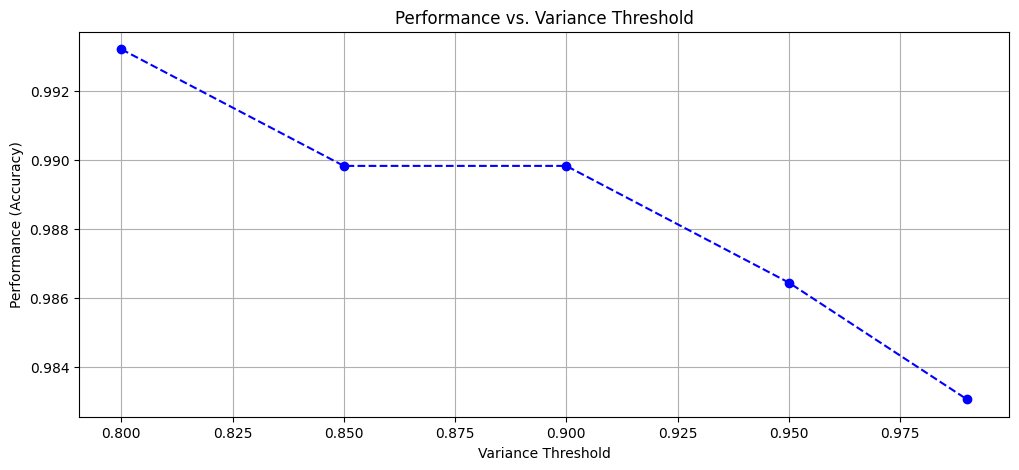

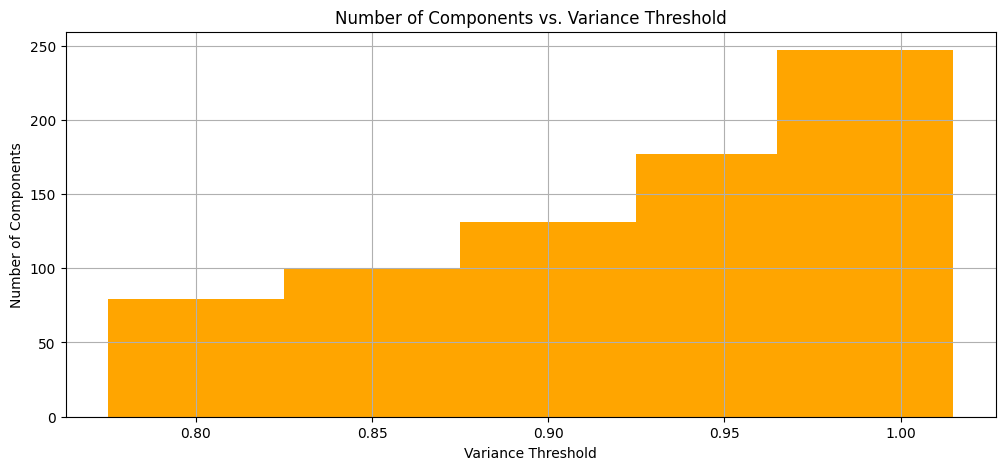

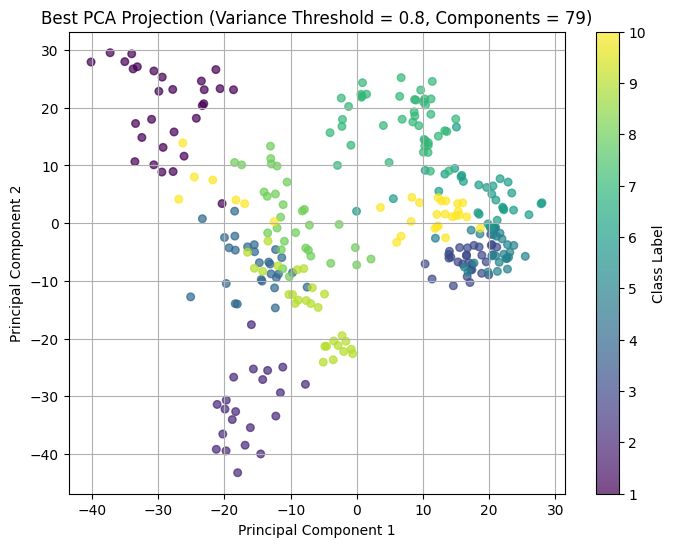

In [10]:
best_pca, best_variance, best_d, best_performance = tune_pca_with_visualizations(
    X_webcam_caf, y_webcam_caf,
    thresholds=[0.80, 0.85, 0.90, 0.95, 0.99],
    classifier=KNeighborsClassifier(n_neighbors=3),
    cv=5,
    save_plots=True,
    plot_prefix="webcam_pca_tuning"
)


# 2. Project the Data onto These Subspaces

After computing the principal components, we project both the source (Webcam) and target (DSLR) datasets into their respective subspaces. The result is Ŝ for the source and T̂ for the target.

In [40]:
# Project the data onto the principal components
S_hat = X_webcam @ webcam_pcs.T  # Projected source data in new subspace
T_hat = X_dslr @ dslr_pcs.T      # Projected target data in new subspace


In [41]:
# Compute the alignment matrix
M = webcam_pcs.T @ dslr_pcs


In [42]:
# Align the source principal components (before projecting the data)
aligned_webcam_pcs = webcam_pcs @ M

# Project the source data (X_webcam_normalized) onto the aligned source subspace
S_hat_aligned = X_webcam @ aligned_webcam_pcs.T


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Fit a 1-NN classifier on the aligned source data
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(S_hat_aligned, y_webcam)

# Predict labels for the target data using the aligned source data
y_pred = knn.predict(T_hat)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_dslr, y_pred)
print(f'Accuracy of subspace alignment: {accuracy:.4f}')


In [ ]:
# Fit a 1-NN classifier on the raw source data (without alignment)
knn_raw = KNeighborsClassifier(n_neighbors=1)
knn_raw.fit(X_webcam, y_webcam)

# Predict labels for the target data without alignment
y_pred_raw = knn_raw.predict(X_dslr)

# Evaluate the accuracy of the classifier on raw data
accuracy_raw = accuracy_score(y_dslr, y_pred_raw)
print(f'Accuracy without alignment: {accuracy_raw:.4f}')


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_dslr, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_dslr, yticklabels=unique_dslr)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Subspace Alignment')
plt.show()


# d tuning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Set a random seed for reproducibility
random_state = 42

# List of d values to test (number of principal components)
d_values = np.arange(1, 58, 1)

# List to store accuracies for each d
accuracies = []
best_accuracy = 0
best_d = 0
best_y_pred = None  # To store the predictions of the best model

# Step 1: Fit the baseline 1-NN classifier without subspace alignment
knn_raw = KNeighborsClassifier(n_neighbors=1)
knn_raw.fit(X_webcam, y_webcam)
y_pred_raw = knn_raw.predict(X_dslr)
accuracy_raw = accuracy_score(y_dslr, y_pred_raw)
print(f'Baseline accuracy without alignment: {accuracy_raw:.4f}')

# Step 2: Perform subspace alignment and compare for different d values
for d in d_values:
    # Compute PCA for source and target with d principal components
    pca_webcam = PCA(n_components=d, random_state=random_state)  # Set random_state
    pca_dslr = PCA(n_components=d, random_state=random_state)    # Set random_state
    
    # Project the data into the subspaces
    Xs = pca_webcam.fit_transform(X_webcam)  # Projected source data
    Xt = pca_dslr.fit_transform(X_dslr)      # Projected target data
    
    # Compute the alignment matrix
    M = pca_webcam.components_.T @ pca_dslr.components_
    
    # Align the source principal components (before projecting the data)
    aligned_webcam_pcs = pca_webcam.components_ @ M
    
    # Project the source data onto the aligned subspace
    S_hat_aligned = X_webcam @ aligned_webcam_pcs.T
    
    # Fit a 1-NN classifier on the aligned source data
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(S_hat_aligned, y_webcam)
    
    # Predict labels for the target data
    y_pred = knn.predict(Xt)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_dslr, y_pred)
    accuracies.append(accuracy)
    
    # Check if this is the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_d = d
        best_y_pred = y_pred  # Store the predictions of the best model
    
    print(f'Accuracy for d={d}: {accuracy:.4f}')

# Step 3: Plot accuracy vs d and include the baseline
plt.figure(figsize=(8, 6))
plt.plot(d_values, accuracies, marker='o', label='Subspace Alignment Accuracy')
plt.axhline(y=accuracy_raw, color='g', linestyle='--', label=f'Baseline Accuracy = {accuracy_raw:.4f}')
plt.axvline(x=best_d, color='r', linestyle='--', label=f'Best d = {best_d}')
plt.title('Accuracy vs Number of Principal Components (d)')
plt.xlabel('Number of Principal Components (d)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Output the best accuracy and corresponding d value
print(f'Best accuracy: {best_accuracy:.4f} at d = {best_d}')

# Step 4: Generate confusion matrix for the best model
cm = confusion_matrix(y_dslr, best_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_dslr), yticklabels=np.unique(y_dslr))
plt.title(f'Confusion Matrix - Best Model (d={best_d})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
